# 文章重新组织

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Clean Data

### 清洗原始数据的每个小表并合成总表

In [2]:
def fill_col_by_last_value(col):
    """
    使用一列最后出现的值填充这一列
    """
    output_list = []
    mask_col = col.isna()
    last_value = col.iloc[0]
    for i in range(len(col)):
        if mask_col.iloc[i]:
            output_list.append(last_value)
        else:
            value = col.iloc[i]
            output_list.append(value)
            last_value = value
    return output_list


def generate_index(length, section=6):
    """
    根据一定的重复（section）为所有数据（length）重新生成编号
    """
    flag = 0
    new_index = []
    for i in range(length):
        if i % section == 0:
            flag += 1
        new_index.append(flag)
    return new_index 

In [3]:
def original_data_clean(data):
    """
    将原始数据进行清理
    """
    
    # 列名清洗
    data.columns = [name.strip() for name in data]
    
    # 将需要空值填充的列填充
    data = data.dropna(axis=0, how='all').dropna(axis=1, how='all')   # 去掉所有空行列
    fill_cols = ['沙埋覆盖情况', '编号']
    for col_name in fill_cols:
        if col_name in data:
            data[col_name] = fill_col_by_last_value(data[col_name])
            print("Fill by the last value in column: {}".format(col_name))
            
    # 合成计算不定根总长度
    column_names = data.columns.tolist()
    if '不定根长' in data:
        root_index = column_names.index('不定根长')
        data['不定根长'] = data.iloc[:, root_index:].sum(axis=1)
        drop_labels = column_names[root_index+1:]
        data.drop(axis=1, labels=drop_labels, inplace=True)
    else:
        data['不定根长'] = 0
    data['不定根长'].fillna(0)

    # 重新编号
    data['编号'] = generate_index(len(data))
    
    # 计算匍匐茎总长度
    data['茎长'] = data[['第一节长', '第二节长', '第三节长']].sum(axis=1)

    return data

In [5]:
origin_data_path = "../data/沙埋数据.xlsx"
sheets = ['迎风坡全埋', '迎风坡半埋', '迎风坡空白']
missing_values = ['—']

merged_data = pd.DataFrame()

for sheet in sheets:
    tmp_data = pd.read_excel(origin_data_path, sheet_name=sheet, na_values=missing_values)
    tmp_data = original_data_clean(tmp_data)
    if sheet == '迎风坡空白':
        tmp_data['沙埋覆盖情况'] = '无'
        tmp_data['沙埋厚度'] = '无'
    else:
        tmp_data['沙埋厚度'] = sheet.strip('迎风坡')
    merged_data = merged_data.append(tmp_data)
    
merged_data['编号'] = generate_index(len(merged_data))
merged_data

Fill by the last value in column: 沙埋覆盖情况
Fill by the last value in column: 编号
Fill by the last value in column: 沙埋覆盖情况
Fill by the last value in column: 编号
Fill by the last value in column: 编号


,沙埋覆盖情况,编号,日期(7月）,备注,第一节长,第二节长,第三节长,株高,不定根数,不定根长,茎长,沙埋厚度
0,三分之一,1,11.0,NaN,13.0,10.0,13.0,19.0,0.0,0.0,36.0,全埋
1,三分之一,1,16.0,NaN,13.0,10.0,16.0,24.0,0.0,0.0,39.0,全埋
2,三分之一,1,20.0,NaN,14.0,11.0,19.0,26.0,0.0,0.0,44.0,全埋
3,三分之一,1,24.0,NaN,14.0,11.0,21.0,27.0,0.0,0.0,46.0,全埋
4,三分之一,1,28.0,NaN,14.0,12.0,21.0,27.0,0.0,0.0,47.0,全埋
...,...,...,...,...,...,...,...,...,...,...,...,...
29,无,35,16.0,NaN,19.0,14.0,27.0,37.0,0.0,0.0,60.0,无
30,无,35,20.0,NaN,20.0,14.0,27.0,40.0,0.0,0.0,61.0,无
31,无,35,24.0,NaN,22.0,14.0,28.0,40.0,0.0,0.0,64.0,无
32,无,35,28.0,NaN,23.0,15.0,28.0,41.0,0.0,0.0,66.0,无


### 对合成后对表转为英语

In [6]:
col_names_eng = {
    '编号': 'num',
    '沙埋覆盖情况': 'bur_x',
    '沙埋厚度': 'bur_y',
    '日期(7月）': 'time',
    '第一节长': 'base',
    '第二节长': 'middle',
    '第三节长': 'apex',
    '茎长': 'length',
    '株高': 'height',
    '不定根数': 'adventitious roots',
    '不定根长': 'total length of adventitious roots',
    '备注': 'note',
    'treatment': 'treatment'
}

sand_burial_eng = {
    '全埋': 'Complete',
    '半埋': 'Half',
    '无': 'No',
    '三分之一': 'Light',
    '三分之二': 'Moderate',
    '三分之三': 'Intense'
}


def clean_merged_data(data):
    data = data.rename(col_names_eng, axis=1)  # 列重命名
    data.replace(sand_burial_eng, inplace=True)
    data['treatment'] = data['bur_y'].str[0] + data['bur_x'].str[0]  # 根据x、y分别的处理方式，为总处理方式标记
    data.replace({'NN': 'CG'}, inplace=True)
    data = data[col_names_eng.values()]
    return data


merged_data = clean_merged_data(merged_data)
merged_data

,num,bur_x,bur_y,time,base,middle,apex,length,height,adventitious roots,total length of adventitious roots,note,treatment
0,1,Light,Complete,11.0,13.0,10.0,13.0,36.0,19.0,0.0,0.0,NaN,CL
1,1,Light,Complete,16.0,13.0,10.0,16.0,39.0,24.0,0.0,0.0,NaN,CL
2,1,Light,Complete,20.0,14.0,11.0,19.0,44.0,26.0,0.0,0.0,NaN,CL
3,1,Light,Complete,24.0,14.0,11.0,21.0,46.0,27.0,0.0,0.0,NaN,CL
4,1,Light,Complete,28.0,14.0,12.0,21.0,47.0,27.0,0.0,0.0,NaN,CL
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,35,No,No,16.0,19.0,14.0,27.0,60.0,37.0,0.0,0.0,NaN,CG
30,35,No,No,20.0,20.0,14.0,27.0,61.0,40.0,0.0,0.0,NaN,CG
31,35,No,No,24.0,22.0,14.0,28.0,64.0,40.0,0.0,0.0,NaN,CG
32,35,No,No,28.0,23.0,15.0,28.0,66.0,41.0,0.0,0.0,NaN,CG


### 确认数据质量

To many missing values in 3
To many missing values in 13
To many missing values in 28


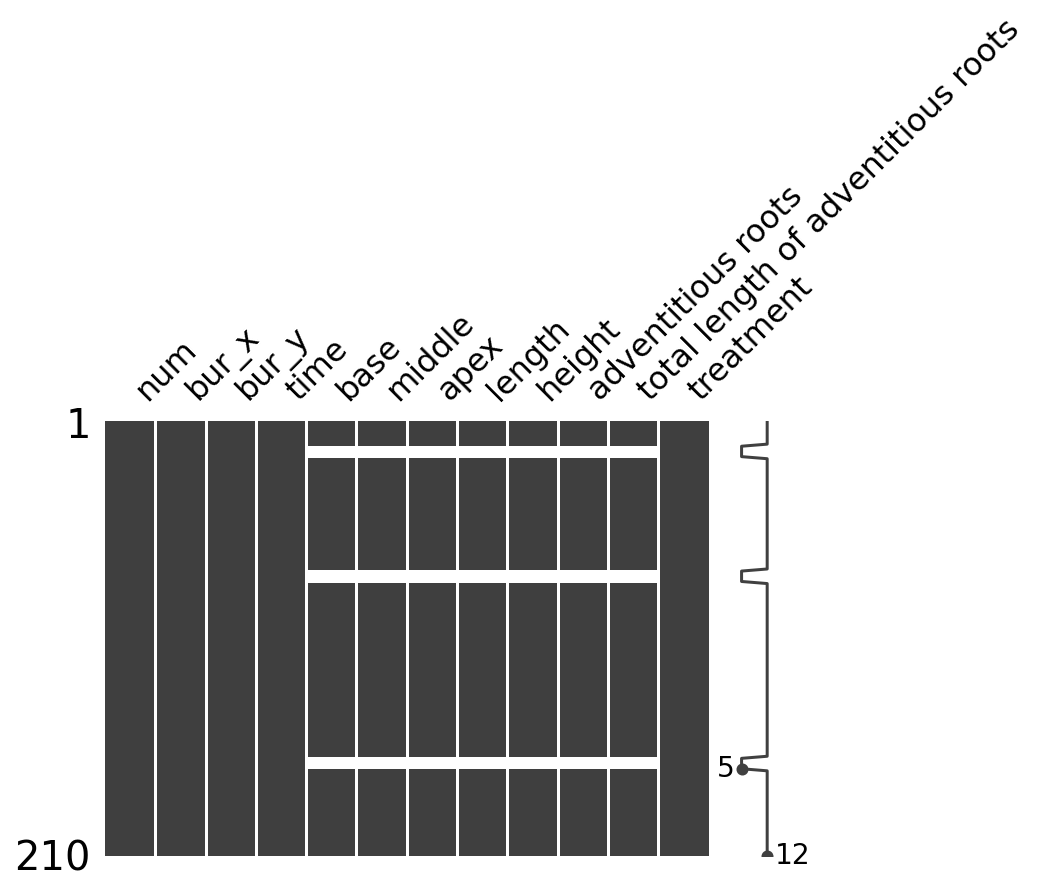

In [7]:
# 匍匐茎和株高不能逆生长
def sort_order_by_growth(col):
    """
    每一颗植株按照其生长规律，不能逆向生长
    col 是每一颗植株（时间不同）的某序列
    返回纠正生长（用上一次测量值代替逆向生长）的序列
    """
    output = []
    last_value = col.iloc[0]
    for value in col.values:
        if value < last_value:
            output.append(last_value)
        else:
            output.append(value)
            last_value = value
    return pd.Series(output, index=col.index)
            
    
# 处理缺失值
def clean_missing_data(data, num):
    check_missing_variables = ['base', 'middle', 'apex', 'length', 'height', 'total length of adventitious roots', 'adventitious roots']  # 检查缺失值的变量
    mean_fill_variables = ['length', 'height', 'total length of adventitious roots', 'adventitious roots']  # 用均值填充的变量
    unreversable_variables = ['length', 'height']  # 不可逆生长的变量
    sections = ['base', 'middle', 'apex']  # 三个部分
    output_data = data[data['num'] == num].copy()  # 这颗植株的数据
    
    # 每个植株，如果缺失值最多的一个变量，超过两天有缺失值，就不要了
    if output_data[check_missing_variables].isna().sum(axis=0).max() > 2:
        print("To many missing values in {}".format(num))
        output_data[check_missing_variables] = np.nan
        return output_data.drop('note', axis=1)
    
    # 丢掉严重有问题的数据
    drop_num = []
    if num in drop_num:
        output_data[check_missing_variables] = np.nan
        return output_data.drop('note', axis=1)
    
    # 用同样处理的、其它植株在此日的平均值进行填补
    for index, row in output_data.iterrows():
        
        if row[check_missing_variables].isna().sum() == 0:  # 需要检查的变量没有缺失值
            continue
        
        else: # 需要检查的变量有缺失值
            treatment = row['treatment']  # 植株的处理方式
            time = row['time']  # 此次测量的时间
            mask1 = data['treatment']==treatment  # 同样的处理方式
            mask2 = data['time']==time  # 同样的测定时间
            mask3 = data['num'] != num  # 其它的植株
            similar_data = data[mask1 & mask2 & mask3]  # 用上述三个条件获取相似的植株
            
            # 首先均值填补
            for variable in mean_fill_variables:
                if variable in unreversable_variables:  # 株高和茎长不可能是0
                    mean = similar_data[similar_data[variable] > 0][variable].mean()
                else:
                    mean = similar_data[variable].mean()
                output_data.loc[index, variable] = round(mean, 0)  # 代替该植株、该日的该变量
                
            # 均值插补处理后，如果各部分长度之间仅存在一个缺失值，就通过加减法获取
            if row[sections].isna().sum() == 1:
                missing_section = row[sections][row.isna()].index.tolist()
                difference = output_data.loc[index, 'length'] - row[sections][row.notna()].sum()
                if difference < 0:  # 如果这样计算行不通，说明这个植株的三分线绑的有问题，用其它的均值来插补
                    row[sections] = np.nan
                output_data.loc[index, missing_section] = difference
            
            # 如果各部分长度缺失值超过一个，则用长度比例数据获取：
            if row[sections].isna().sum() > 1:
                ratios = similar_data[sections].sum(axis=0) / similar_data['length'].sum()
                output_data.loc[index, sections] = output_data.loc[index, 'length'] * ratios
                
#     # 判断逆生长问题
#     for v in unreversable_variables:
#         output_data[v] = sort_order_by_growth(output_data[v])
        
    # 如果没有不定根总长度，那一定没有不定根
    no_roots_mask = output_data['total length of adventitious roots'] == 0
    output_data.loc[no_roots_mask, 'adventitious roots'] = 0
    
    return output_data.drop('note', axis=1)


# 处理全部的数据：
cleaned_data = pd.DataFrame()
for num in merged_data['num'].unique():
    output = clean_missing_data(merged_data, num)
    cleaned_data = cleaned_data.append(output)
    
# 快速根据编号确认数据
def check_original_data_by_num(num):
    df = merged_data[merged_data['num'] == num]
    return df

def check_cleaned_data_by_num(num):
    df2 = cleaned_data[cleaned_data['num'] == num]
    return df2


import missingno as msno
msno.matrix(cleaned_data, figsize=(6, 4));

绘制按照时间变化的每个样本，看看是否有不合理之处

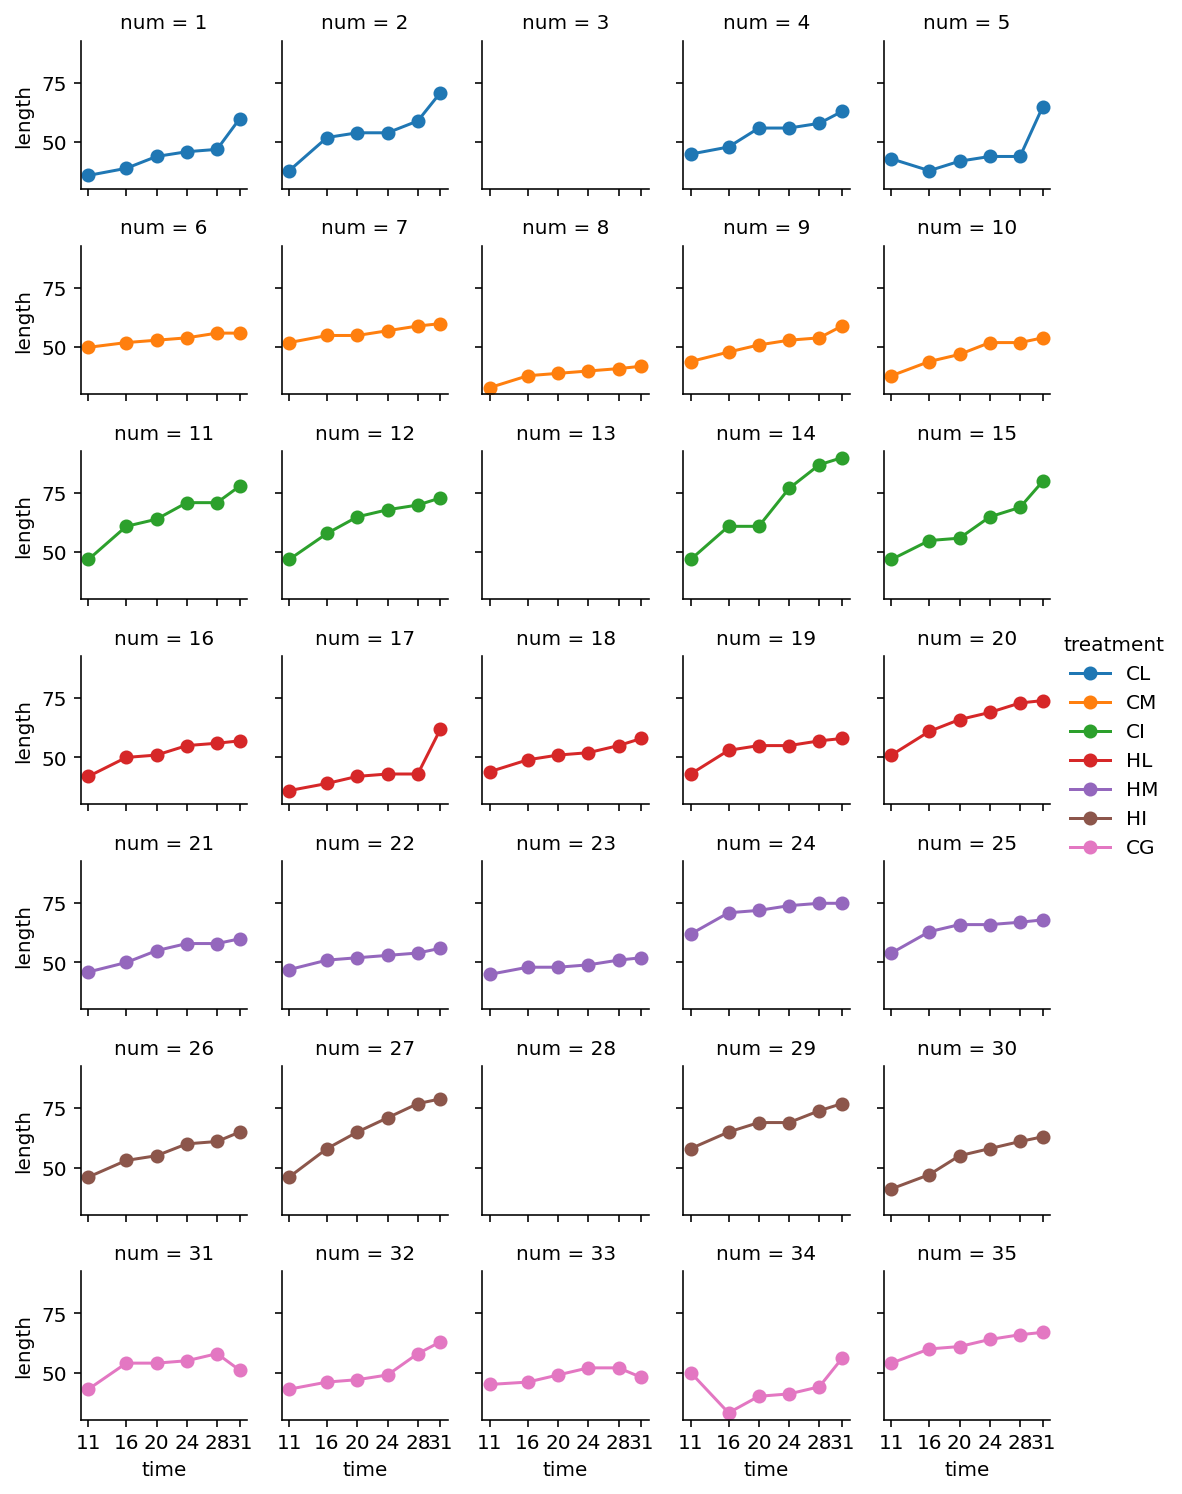

In [8]:
# sns.set_theme(style="ticks")

def plot_facegrid_by_time(data, y):
    grid = sns.FacetGrid(
        data,
        col='num',
        hue='treatment',
        col_wrap=5,
        height=1.5
    )

    grid.map(plt.plot, "time", y, marker="o")
    grid.set(
        xticks=merged_data['time'].unique(),
#         ylim=(0,100)
    )
    grid.add_legend()
    return 
    
    
# 丢掉一些数据
plot_facegrid_by_time(cleaned_data, 'length')

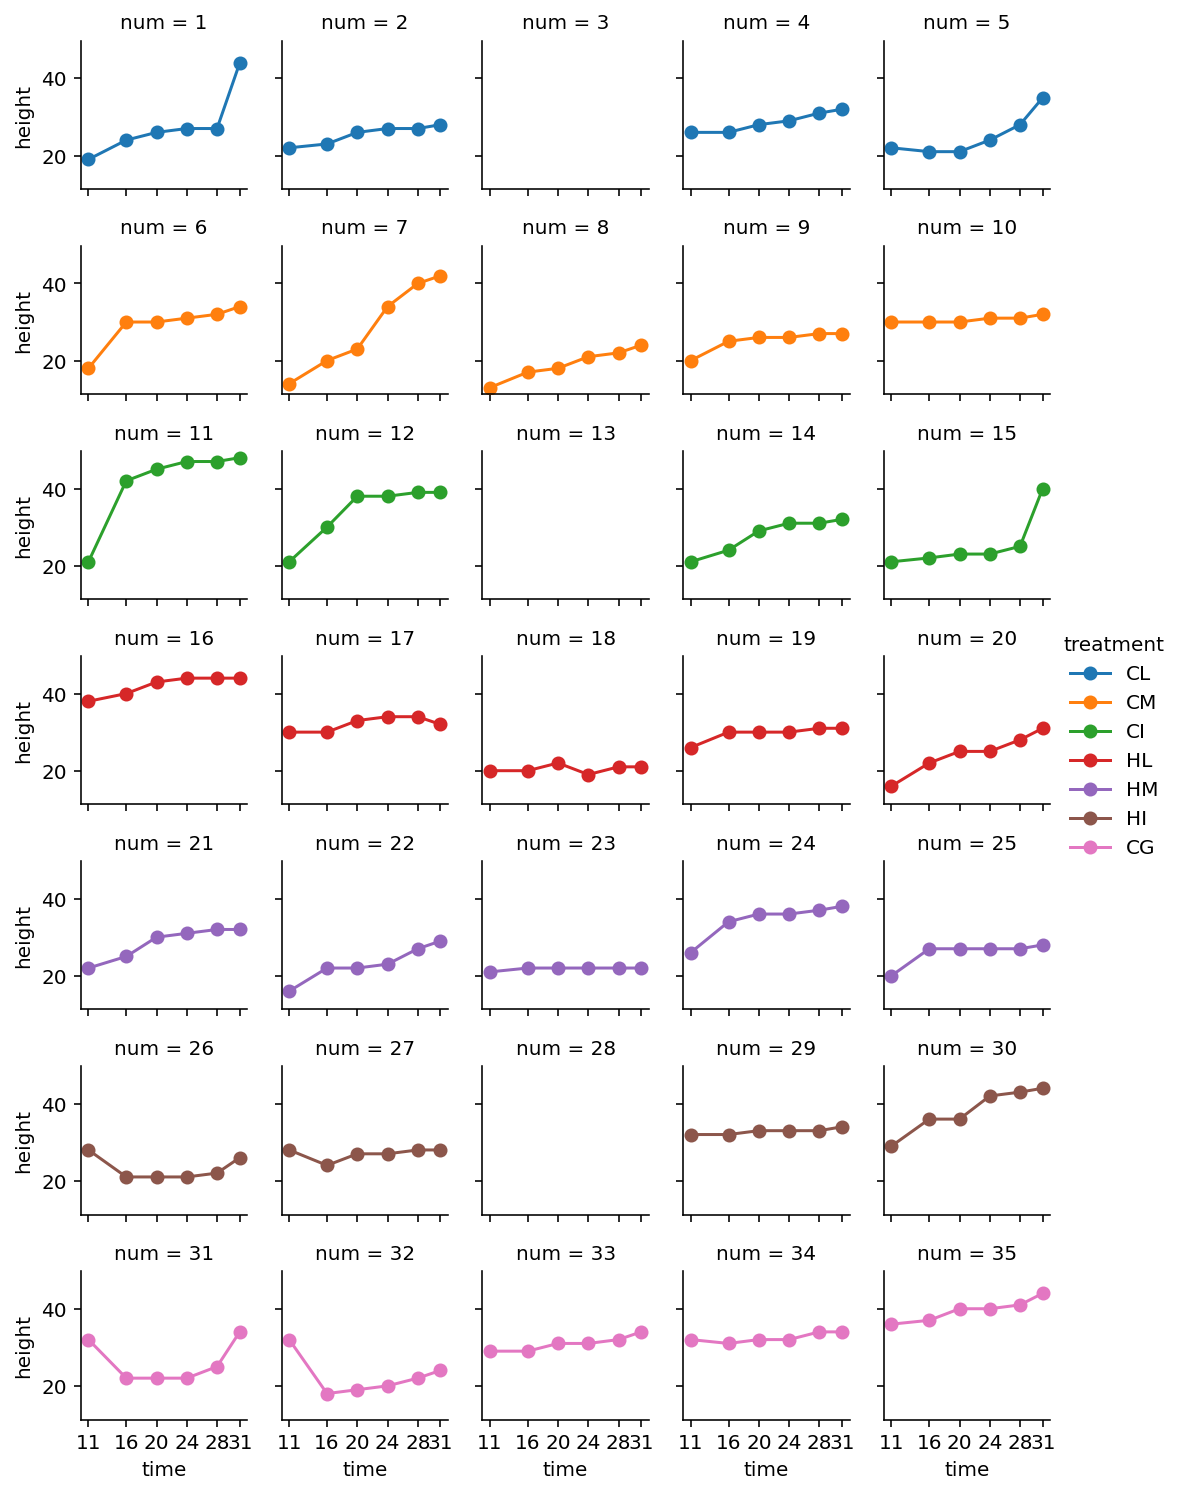

In [9]:
plot_facegrid_by_time(cleaned_data, 'height')

## 修改图1. 株高和茎长

现在只讨论迎风坡：

株高不受显著影响，匍匐茎长度显著增加。

进行重复测量的方差分析

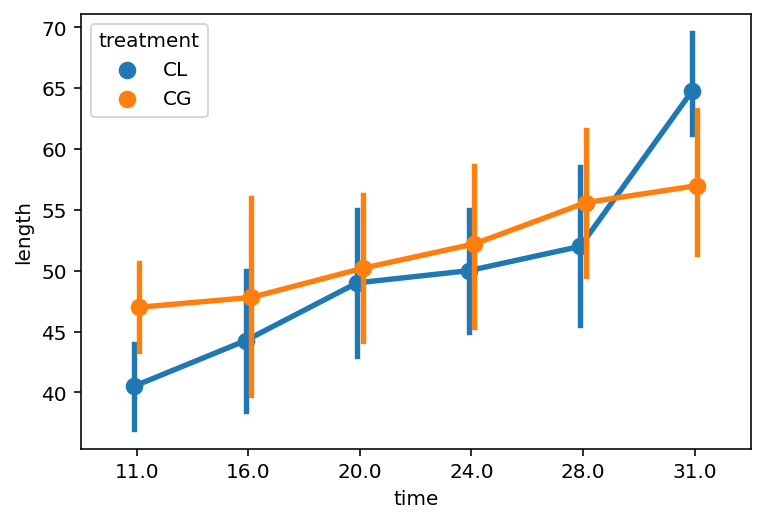

In [10]:
def choose_compare_data(treatment, data=cleaned_data):
    """
    按照处理类型选择数据以进行分析
    treatment: 需要进行对比的数据，列表或者单独某个处理（和空白进行对照）
    data: 输入的总体清理后数据
    """
    if type(treatment) is str:
        use_data = data[(data['treatment'] == 'CG') | (data['treatment'] == treatment)]
    else:
        use_data = pd.DataFrame()
        for treat in treatment:
            mask = data['treatment'] == treat
            use_data = use_data.append(data[mask])
    return use_data


def compare_plot(data):
    sns.pointplot(
        data = data,
        x = 'time',
        y = 'length',
        hue = 'treatment',
        dodge = True
    )
    
    
test_data = choose_compare_data('CL')
compare_plot(test_data)

### 两两和空白对照进行对比

In [15]:
import pingouin as pg

treatments = cleaned_data['treatment'].unique().tolist()
treatments.remove('CG')
mixed_anova = pd.DataFrame()

for treatment in treatments:
    data = choose_compare_data(treatment)
    anova = data.mixed_anova(dv = 'length', within='time', between='treatment', subject='num')
    mixed_anova = mixed_anova.append(pd.Series(data=anova['p-unc'].values, index=anova['Source'], name=treatment))
    
mixed_anova

,Interaction,time,treatment
CL,0.042573,7.407838e-08,0.712670
CM,0.903252,1.224175e-06,0.644075
CI,0.000181,3.917931e-10,0.007972
HL,0.335581,5.174162e-08,0.719486
HM,0.598447,8.538310e-07,0.235461
HI,0.027110,8.840044e-09,0.070327


In [16]:
posthocs = pg.pairwise_ttests(
    dv = 'length',
    within = 'time',
    between = 'treatment',
    subject = 'num',
    data = test_data
)

pg.print_table(posthocs)


POST HOC TESTS

Contrast          time    A     B     Paired    Parametric         T    dof  Tail         p-unc     BF10    hedges
----------------  ------  ----  ----  --------  ------------  ------  -----  ---------  -------  -------  --------
time              -       11.0  16.0  True      True          -0.700  8.000  two-sided    0.504    0.394    -0.280
time              -       11.0  20.0  True      True          -2.183  8.000  two-sided    0.061    1.582    -0.837
time              -       11.0  24.0  True      True          -2.900  8.000  two-sided    0.020    3.701    -1.072
time              -       11.0  28.0  True      True          -3.642  8.000  two-sided    0.007    8.887    -1.413
time              -       11.0  31.0  True      True          -5.061  8.000  two-sided    0.001   41.961    -2.363
time              -       16.0  20.0  True      True          -3.705  8.000  two-sided    0.006    9.563    -0.419
time              -       16.0  24.0  True      True          -

## 不定根对比

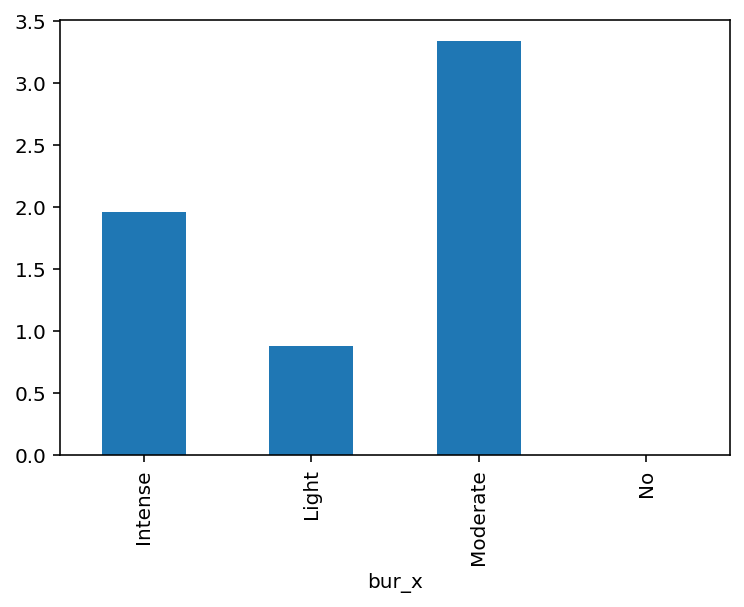

In [21]:
cleaned_data.groupby('bur_x')['total length of adventitious roots'].mean().plot.bar()

## 植株干重对比

In [18]:
weight = pd.read_excel("../data/植株干重.xlsx").drop(0)
for col in weight:
    weight[col] = fill_col_by_last_value(weight[col])
    
columns_name = [
    'bur_y', 'bur_x',
    'base root', 'base stem', 'base leaf',
    'middle root', 'middle stem', 'apex leaf',
    'apex root', 'apex stem', 'apex leaf'
]

weight = weight.rename({x: columns_name[i] for i, x in enumerate(weight.columns)}, axis=1)
weight.loc[1, 'bur_x'] = 'Control group'
weight['treatment'] = weight['bur_y'].str[0] + weight['bur_x'].str[0]
weight.replace({'CC': 'CG'}, inplace=True)

weight

,bur_y,bur_x,base root,base stem,base leaf,middle root,middle stem,apex leaf,apex root,apex stem,apex leaf,treatment
1,Control group,Control group,0.1±0.2,20.2±4.1,18.2±7.4,0.0±0.0,13.7±3.7,16.4±6.8,0.0±0.0,12.6±7.7,18.5±6.0,CG
2,Half sand burial,Light,0.0±0.0,16.6±2.4,14.1±4.2,0.0±0.0,19.4±4.7,21.6±5.0,0.0±0.0,8.2±3.3,19.8±7.5,HL
3,Half sand burial,Moderate,1.4±1.3,22.1±1.8,20.3±4.9,0.1±0.1,12.5±3.6,16.2±1.7,0.0±0.0,8.1±2.2,18.9±8.1,HM
4,Half sand burial,Intense,0.6±0.5,21.0±3.9,18.1±2.9,0.0±0.0,10.3±4.0,17.9±6.7,0.0±0.0,8.3±2.6,23.4±7.4,HI
5,Complete sand burial,Light,0.2±0.4,14.1±5.7,19.3±6.5,0.0±0.0,12.0±1.4,22.5±2.3,0.0±0.0,8.3±4.1,23.3±7.4,CL
6,Complete sand burial,Moderate,1.8±1.6,16.2±4.2,13.3±7.1,0.0±0.0,11.7±5.2,23.4±13.9,0.0±0.0,6.8±2.3,26.5±8.7,CM
7,Complete sand burial,Intense,0.9±1.4,21.7±3.9,22.6±5.7,0.1±0.3,11.1±2.8,19.0±5.0,0.0±0.0,7.5±2.7,16.6±6.0,CI


In [19]:
locations = ['root', 'stem', 'leaf']
sections = ['base', 'middle', 'apex']

def compare_dry_weight(treatment):
    if type(treatment) is str:
        mask1 = weight['treatment'] == 'CG'
        mask2 = weight['treatment'] == treatment
        return weight[mask1 | mask2]
                
    else:
        pass
    

compare_dry_weight('CI')

,bur_y,bur_x,base root,base stem,base leaf,middle root,middle stem,apex leaf,apex root,apex stem,apex leaf,treatment
1,Control group,Control group,0.1±0.2,20.2±4.1,18.2±7.4,0.0±0.0,13.7±3.7,16.4±6.8,0.0±0.0,12.6±7.7,18.5±6.0,CG
7,Complete sand burial,Intense,0.9±1.4,21.7±3.9,22.6±5.7,0.1±0.3,11.1±2.8,19.0±5.0,0.0±0.0,7.5±2.7,16.6±6.0,CI
